In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install split-folders[full]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
## IMPORTS 
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import random 
import torch
import torchvision 
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as T

#import torchvision
#from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 


import splitfolders
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
import glob
import time
import PIL
from PIL import Image
import os

In [4]:
#LOADING DATA 

# Original images 
full_data_path= '/content/drive/MyDrive/medium_structure_model/images_128_patches_small'
output_images='/content/drive/MyDrive/medium_structure_model/images_128_patches_small_split'

#Associated depth maps
full_depth_maps_path = '/content/drive/MyDrive/medium_structure_model/depth_maps_128_patches_small'
output_depth_maps='/content/drive/MyDrive/medium_structure_model/depth_maps_128_patches_small_split'

In [5]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [6]:
# Activate cuda
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cpu


In [7]:
#Splitting the data into train, test, val

#splitfolders.ratio(full_data_path, output=output_images, seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False) # default values
#splitfolders.ratio(full_depth_maps_path, output=output_depth_maps, seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)
#step done, uncomment if you need to split other files 

In [8]:
#Final paths:

train_images_path='/content/drive/MyDrive/medium_structure_model/images_128_patches_small_split/train/class0'
test_images_path='/content/drive/MyDrive/medium_structure_model/images_128_patches_small_split/test/class0'
val_images_path='/content/drive/MyDrive/medium_structure_model/images_128_patches_small_split/val/class0'


train_depth_maps_path='/content/drive/MyDrive/medium_structure_model/depth_maps_128_patches_small_split/train/class0'
test_depth_maps_path='/content/drive/MyDrive/medium_structure_model/depth_maps_128_patches_small_split/test/class0'
val_depth_maps_path='/content/drive/MyDrive/medium_structure_model/depth_maps_128_patches_small_split/val/class0'




In [9]:
# GLOBAL VARIABLES

image_size=128  

In [10]:
#LOADING DATA

def load_data(data_path, verbose=False):
    DATA_LOADED=False 
    print_every_n_loads=10
    images=[]
    ind=0
    t0=time.time()
    if not DATA_LOADED:
        print('Loading data...')
    for filename in os.listdir(data_path):
        img = mpimg.imread(os.path.join(data_path, filename))
        if img is not None:
            images.append(np.asarray(img))
            ind+=1
        if verbose:
            if ind%print_every_n_loads==0:
                print('nb of data loaded:', ind)
    print(f'Loaded data in: {time.time()-t0 } s')
    return images

train_images=load_data(train_images_path)
val_images=load_data(val_images_path)
test_images=load_data(test_images_path)

train_depth_maps=load_data(train_depth_maps_path)
val_depth_maps=load_data(val_depth_maps_path)
test_depth_maps=load_data(test_depth_maps_path)

Loading data...
Loaded data in: 2.6182594299316406 s
Loading data...
Loaded data in: 0.29918789863586426 s
Loading data...
Loaded data in: 0.30347609519958496 s
Loading data...
Loaded data in: 2.082798480987549 s
Loading data...
Loaded data in: 0.19986438751220703 s
Loading data...
Loaded data in: 0.1814429759979248 s


In [11]:
DATA_LOADED=True
NUM_TRAIN=len(train_images)
NUM_VAL=len(val_images)
NUM_TEST=len(test_images)

Image dimensions : 128*128
data type : float32


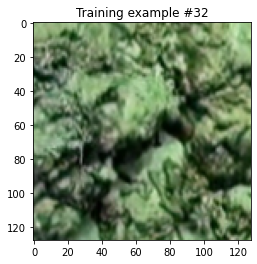

In [12]:
# Some information about the dataset
data_type = train_images[0][0].dtype
H, W, C=train_images[0].shape
#print("Training dataset length :", NUM_TRAIN)
#print("Validation dataset length :", NUM_VAL)
print(f"Image dimensions : {H}*{W}")
print("data type :", data_type)
plt.imshow(train_images[32])
plt.title(f"Training example #{32}")
plt.show()


In [13]:
print(np.shape(train_images))

(721, 128, 128, 3)


In [14]:
def get_mean_std(fulldata):
      eps=1e-5
      mean=np.mean(np.mean(np.mean(fulldata, axis=1), axis=1), axis=0)
      std=np.std(np.std(np.std(fulldata, axis=1), axis=1), axis=0)+eps
      return mean, std

In [15]:
from matplotlib.colors import Normalize
## CREATING A CUSTOM DATASET STRUCTURE WHERE THE DEPTH MAP IS THE LABEL

# https://towardsdatascience.com/beginners-guide-to-loading-image-data-with-pytorch-289c60b7afec: interesting website

class Original_and_Depth_Map(torch.utils.data.Dataset):

    def __init__(self, datasetA, datasetB, transform=False):
        self.datasetA = np.array(datasetA).astype(np.uint8)
        self.datasetB = np.array(datasetB).astype(np.uint8)
        self.meanA, self.stdA=get_mean_std(datasetA)
        self.meanB, self.stdB=get_mean_std(datasetB)
        self.transformA = T.Compose([T.ToTensor()
       , T.Normalize(self.meanA, self.stdA)
        ])
        self.transformB = T.Compose([  T.ToTensor(), T.Normalize(self.meanB, self.stdB),
       ])
    

        
    def __getitem__(self, index):
        xA = self.datasetA[index]
        xB = self.datasetB[index]
        tA=self.transformA(xA)
        tB=self.transformB(xB)
        return tA, tB

    def __len__(self):
        return len(self.datasetA)



In [16]:
batch_size = 32

train_dataset =Original_and_Depth_Map(train_images, train_depth_maps)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)

val_dataset =Original_and_Depth_Map(val_images, val_depth_maps)
val_loader = DataLoader(val_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)

test_dataset =Original_and_Depth_Map(test_images, test_depth_maps)
test_loader = DataLoader(test_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [17]:
for i in range (len(train_dataset)):
  sample=train_dataset[i]
  print(i, sample[0].size(), sample[1].size())
  if i==3:
    break

0 torch.Size([3, 128, 128]) torch.Size([1, 128, 128])
1 torch.Size([3, 128, 128]) torch.Size([1, 128, 128])
2 torch.Size([3, 128, 128]) torch.Size([1, 128, 128])
3 torch.Size([3, 128, 128]) torch.Size([1, 128, 128])


In [18]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(torchvision.utils.make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    
def show_batch(dl, nmax=64):
    for images in dl:
        show_images(images[0], nmax)
        break

In [19]:
### DESIGNING THE MODEL 

class Simple_Autoencoder(nn.Module):
  def __init__(self):
        super(Simple_Autoencoder, self).__init__()
        
        
        self.encoder = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=2, stride=2, padding=0), nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=2, stride=2, padding=0), nn.ReLU(), 
        nn.Conv2d(128, 256, kernel_size=2, stride=2), nn.ReLU()
        )
        
        #nn.Conv2d(256, 512, kernel_size=2, stride=2), nn.ReLU()
        #nn.ConvTranspose2d(512, 256, 2, stride=2), nn.ReLU(),
        
        
        self.decoder = nn.Sequential(
        nn.ConvTranspose2d(256,128, 2, stride=2), 
        nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU(),
        nn.ConvTranspose2d(64, 1, 2, stride=2)
        )

  def forward(self, x):
      z=self.encoder(x)
      return self.decoder(z)
  

In [20]:
#Checking output size

from torchsummary import summary

ae=Simple_Autoencoder()
input=torch.zeros((3,128,128))
summary(ae, input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]             832
              ReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3          [-1, 128, 32, 32]          32,896
              ReLU-4          [-1, 128, 32, 32]               0
            Conv2d-5          [-1, 256, 16, 16]         131,328
              ReLU-6          [-1, 256, 16, 16]               0
   ConvTranspose2d-7          [-1, 128, 32, 32]         131,200
   ConvTranspose2d-8           [-1, 64, 64, 64]          32,832
              ReLU-9           [-1, 64, 64, 64]               0
  ConvTranspose2d-10          [-1, 1, 128, 128]             257
Total params: 329,345
Trainable params: 329,345
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 12.12
Params size (MB): 1.26
Estimated 

In [21]:
# Defining the model and the parameters

autoencoder=Simple_Autoencoder()

# Choose learning rate
lr = 1e-3

# Choose optimizer
optim = torch.optim.Adam(autoencoder.parameters(), lr=lr, weight_decay=1e-3) 

In [22]:
# Checking input sizes by hand 

input=torch.zeros((3,128,128))
print("Input size:", input.size())


print('\n #----Encoder Part-----')
output= nn.Conv2d(3, 64, kernel_size=2, stride=2, padding=0)(input)
print( 'first output size: ', output.size())
output1=nn.Conv2d(64, 128, kernel_size=2, stride=2, padding=0)(output)
print( 'second output size: ', output1.size())
output2=nn.Conv2d(128, 256, kernel_size=2, stride=2)(output1)
print( 'third output size: ', output2.size())

print(' \n# ----Decoder Part-----')

output3=nn.ConvTranspose2d(256,128, 2, stride=2)(output2)
print(" ConvTranspose2d size:", output3.size())
output4=nn.ConvTranspose2d(128, 64, 2, stride=2)(output3)
print(" ConvTranspose2d size:", output4.size())
output5= nn.ConvTranspose2d(64, 1, 2, stride=2)(output4)
print(" 2nd ConvTranspose2d size:", output5.size())



Input size: torch.Size([3, 128, 128])

 #----Encoder Part-----
first output size:  torch.Size([64, 64, 64])
second output size:  torch.Size([128, 32, 32])
third output size:  torch.Size([256, 16, 16])
 
# ----Decoder Part-----
 ConvTranspose2d size: torch.Size([128, 32, 32])
 ConvTranspose2d size: torch.Size([64, 64, 64])
 2nd ConvTranspose2d size: torch.Size([1, 128, 128])


In [23]:
#Checking size compatibility
d_test=autoencoder.forward(torch.zeros((3,128,128)))
print(d_test.size())
#It works !

torch.Size([1, 128, 128])


In [24]:
## Training function

## Training function
def train_epoch(network, device, dataloader, optimizer, print_every = 1):
    """ Trains the simple model for one epoch. losses_resolution indicates how often training_loss should be printed and stored. """
    network.train()
    train_losses = []
    # Iterate the dataloader (We do not need the label value which is 0 here, the depth maps are the labels)
    iter = 0
    for image, depth_map in dataloader:  # shape=(el, label) --> image= (el, 0)  depth_map=(el, 0)  d= [image, depth_map]
        #print(voltage)
        im = image[0].to(device)
        #print("im shape:", im.shape)
        d= depth_map[0].to(device)
        #print("d shape:", d.shape)
        
        iter += 1
        d_hat = network(im)

        
        #print("d_hat shape:", d_hat.shape)
        # Evaluate loss
        loss = ((d - d_hat)**2).sum() 

        # Backward pass
        optimizer.zero_grad()  # Sets the gradients attached to the parameters objects to zero.
        loss.backward()  # Uses the gradient object attached to the loss to recursively compute the gradients of the parameters of the network (and store their value in the gradient objects attached to said parameters)
        optimizer.step()  # Actually chages the values of the parameters using their gradients, computed on the previous line of code.
        
        # Print and store batch loss
        batch_loss = loss.item()/d.shape[0]
        train_losses.append(batch_loss)
        
        #Display
        #if iter%print_every == 0:
            #print(f'\t partial train loss (single batch): {batch_loss:.2f}')
    return train_losses


In [25]:
### Testing function

def validation_epoch(network, device, dataloader):
    "Set evaluation mode for encoder and decoder"

    network.eval()  # evaluation mode, equivalent to "network.train(False)""
    val_loss = 0
    with torch.no_grad(): # No need to track the gradients
        for image, depth_map in dataloader:
            im = image[0].to(device)
            d = depth_map[0].to(device)
            # Move tensor to the proper device
            # h = h.to(device)
            d_hat = network(im)
            loss = ((d - d_hat)**2).sum() 
            val_loss += loss.item()/d.shape[0]

    return val_loss/len(dataloader)

In [26]:
#Plotting the learning and validation loss curves


def plot_learning_curves(train_losses, val_losses):
    """ Plots the learning curve. Losses resolution (how many times the loss is displayed) is one value per batch for the training losses, and one value per epoch for the validation. """
    iterations_train = np.arange(0, batch_size*train_losses.size, batch_size)
    iterations_validation = np.arange(0, NUM_TRAIN*val_losses.size, NUM_TRAIN)

    fig, ax = plt.subplots(figsize=(10, 10))

    ax.plot(iterations_train, train_losses, color="blue", label="training loss")
    ax.plot(iterations_validation, val_losses, color="orange", label = "validation loss")
    ax.set(xlabel="iterations", ylabel="loss", title="Training and validation losses over iterations")
    ax.grid()
    ax.legend()

    fig.show()

In [28]:
print(test_dataset[0][0].size())

torch.Size([3, 128, 128])


In [29]:
#Testing the trained network on test data

def plot_ae_outputs(ae, number_outputs=5, random_plots=True, indices=None):
  """
    When random_plots = True, different images are taken between each epoch.
    When random_plots = False, indices indicates what images to plot
  """
  fig = plt.figure(figsize=(5*number_outputs,8.5))
  
  #Selection of random images to plot within the dataset or a select set of indices
  if random_plots:
      plotted_samples = np.random.choice(NUM_TEST, number_outputs)
  else:
      plotted_samples = indices
  
  for i in range(number_outputs):
      ax = plt.subplot(2, number_outputs, i+1)
      # plt.subplot(nb_rows, nb_cols, num)  where num is indexed from 1
      img = test_dataset[plotted_samples[i]][0].unsqueeze(0) # unsqueeze so that the image can be interpreted as a single-sampled batch, to fit in the ae
      ae.eval()
      
      with torch.no_grad():
        output_img  = ae(img)
     
      
      plt.imshow((np.transpose(img.cpu().squeeze().numpy())*255).astype(np.uint8))
      plt.colorbar()
      ax.set_xlabel(f"$v_{{max}}={img.max():.2f}$")
      
      if i == number_outputs//2:
          ax.set_title('Original depth maps')
      ax = plt.subplot(2, number_outputs, i + 1 + number_outputs)
      plt.imshow((np.transpose(output_img.cpu().squeeze().numpy())*255).astype(np.uint8))
      plt.colorbar()
      ax.set_xlabel(f"$profondeur_{{max}}={output_img.max():.2f} m $")
      
      
      if i == number_outputs//2:
          ax.set_title('Reconstructed depth maps')
  return fig




 EPOCH 1/10 	 train loss 3.069 	 val loss 4.803

 EPOCH 2/10 	 train loss 0.054 	 val loss 2.512

 EPOCH 3/10 	 train loss 0.001 	 val loss 1.907

 EPOCH 4/10 	 train loss 0.063 	 val loss 1.701

 EPOCH 5/10 	 train loss 0.011 	 val loss 0.582

 EPOCH 6/10 	 train loss 0.002 	 val loss 2.157

 EPOCH 7/10 	 train loss 0.000 	 val loss 2.089

 EPOCH 8/10 	 train loss 0.001 	 val loss 2.134

 EPOCH 9/10 	 train loss 0.000 	 val loss 2.060

 EPOCH 10/10 	 train loss 0.626 	 val loss 3.393


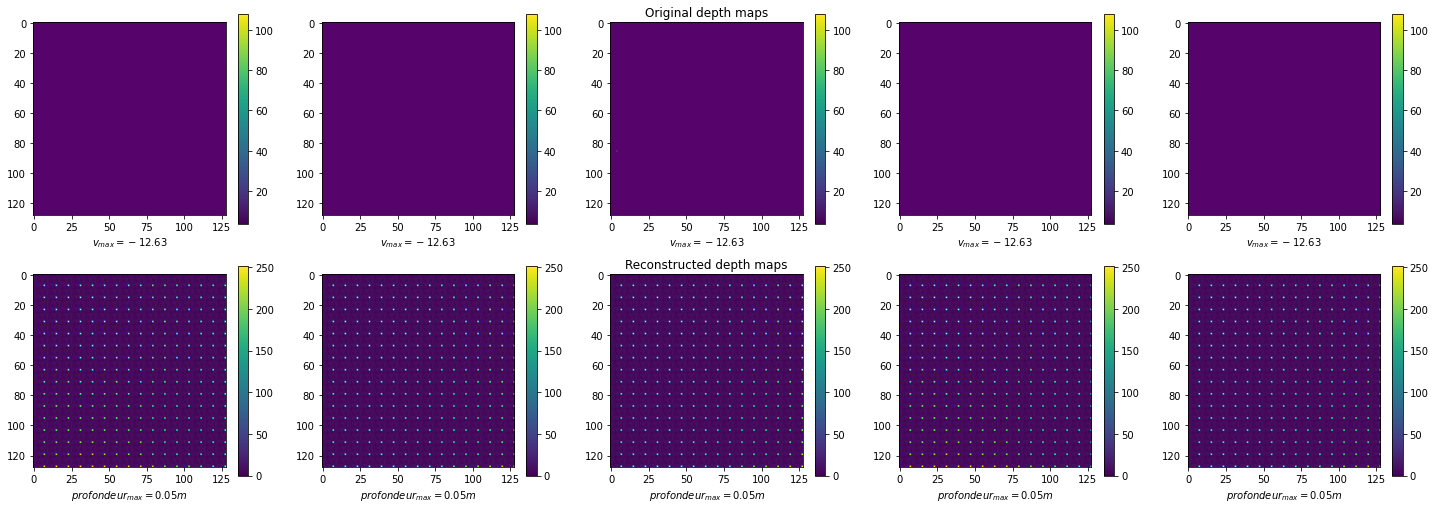

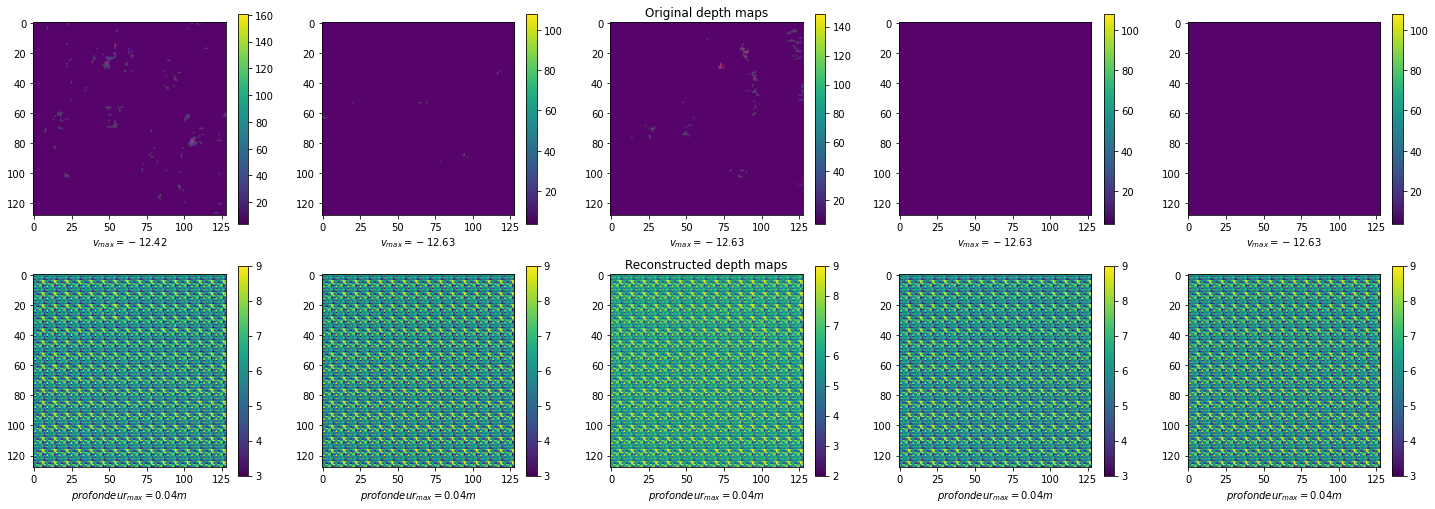

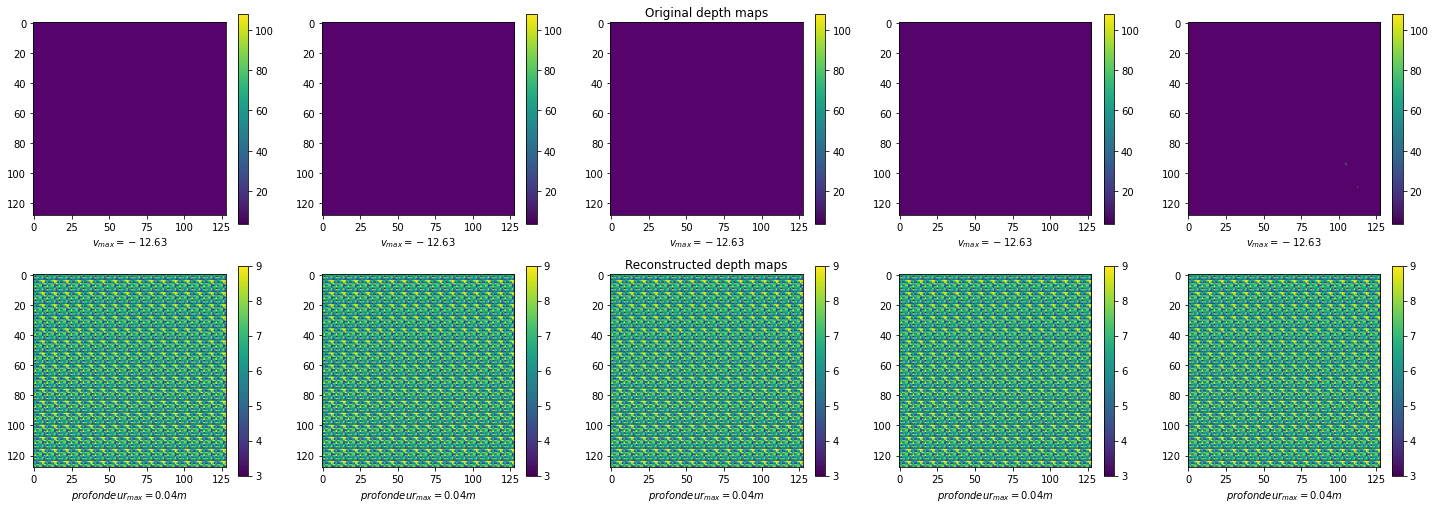

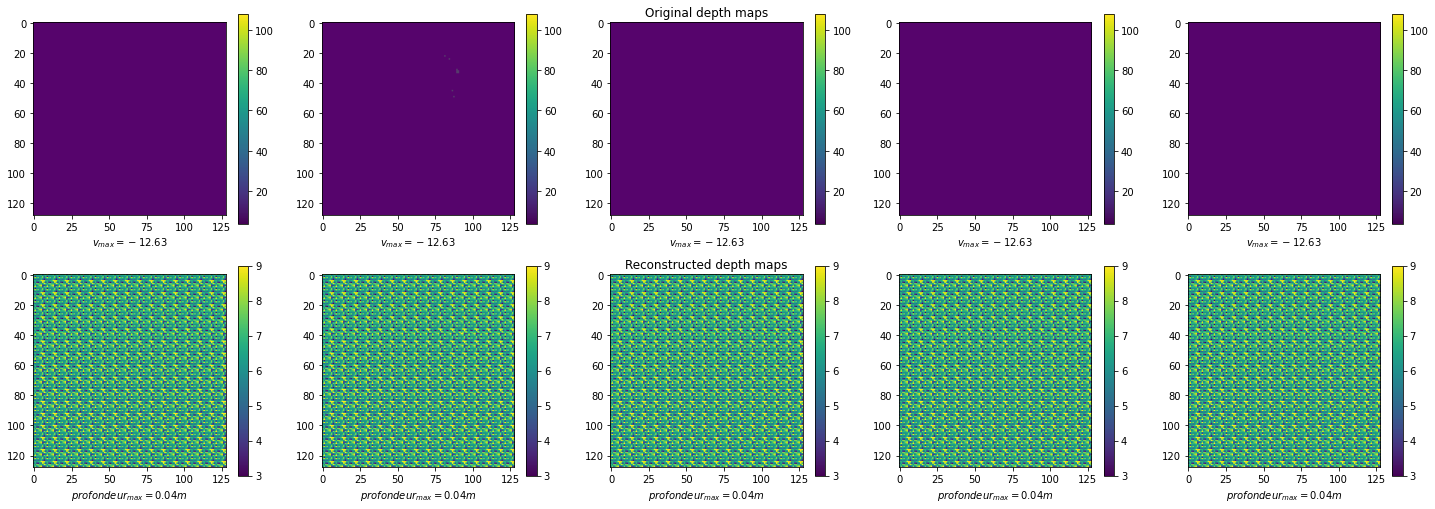

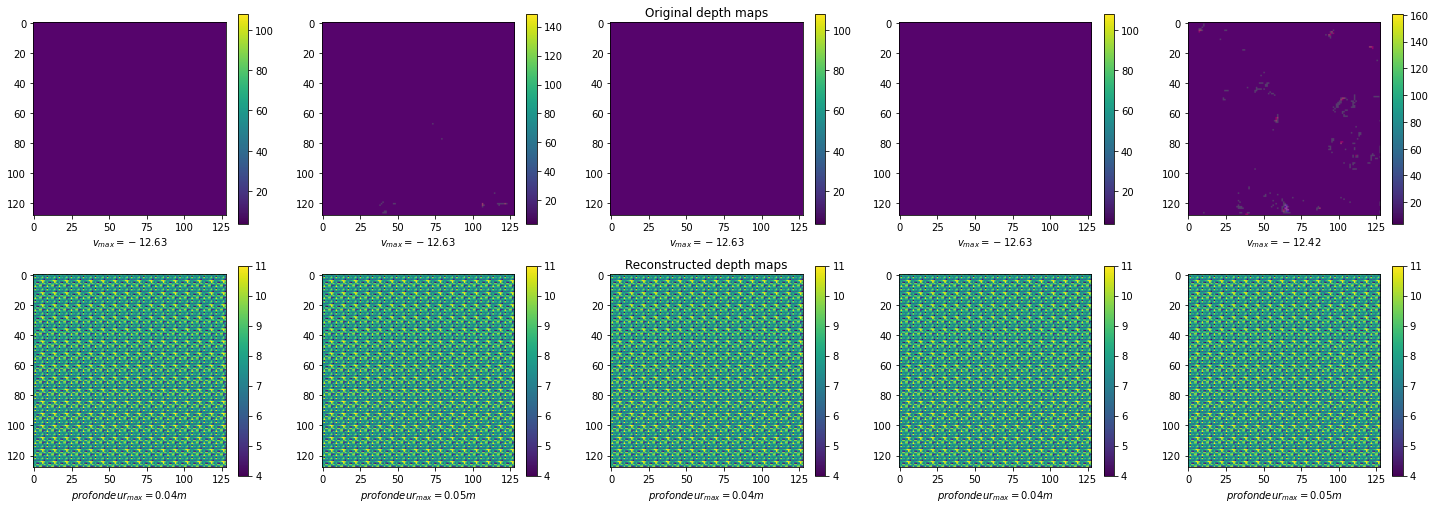

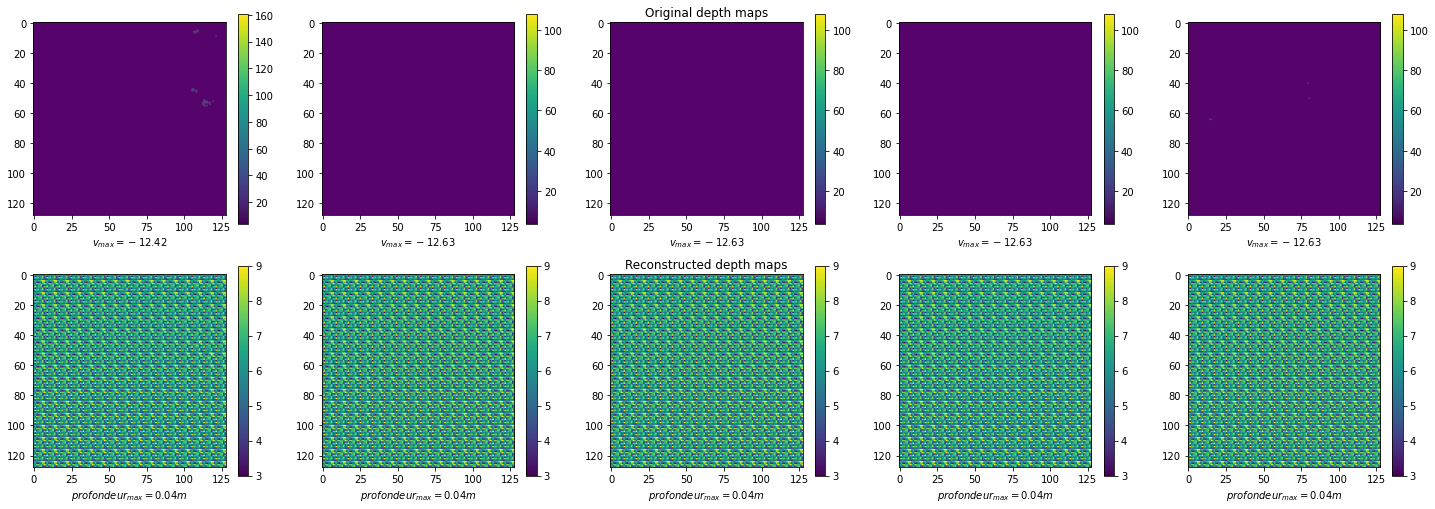

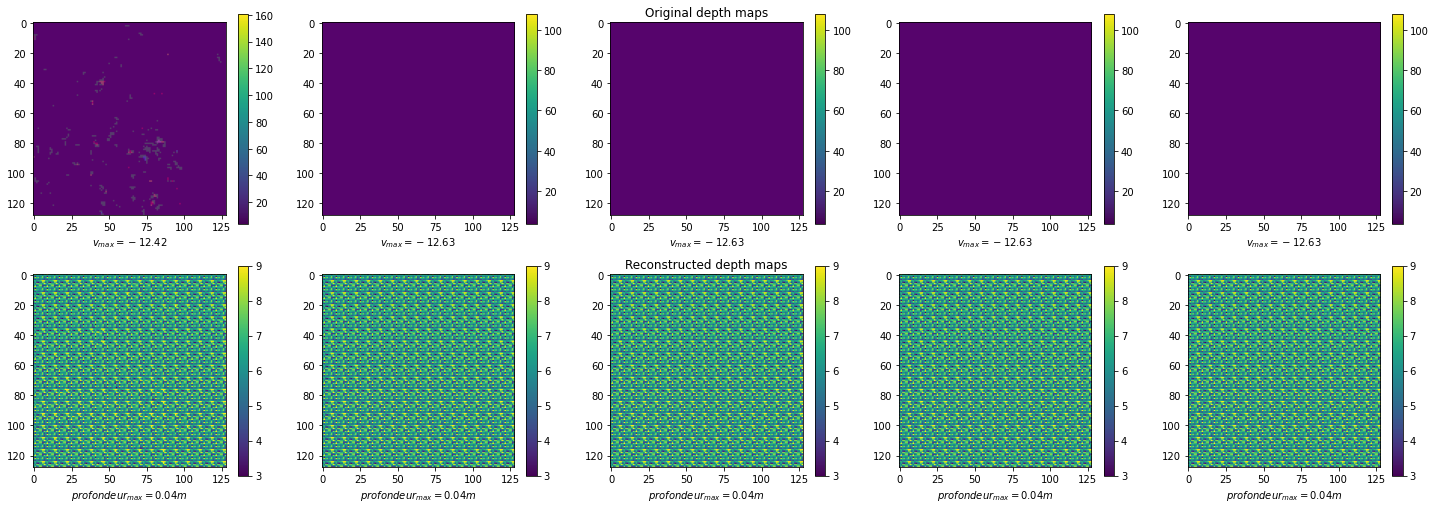

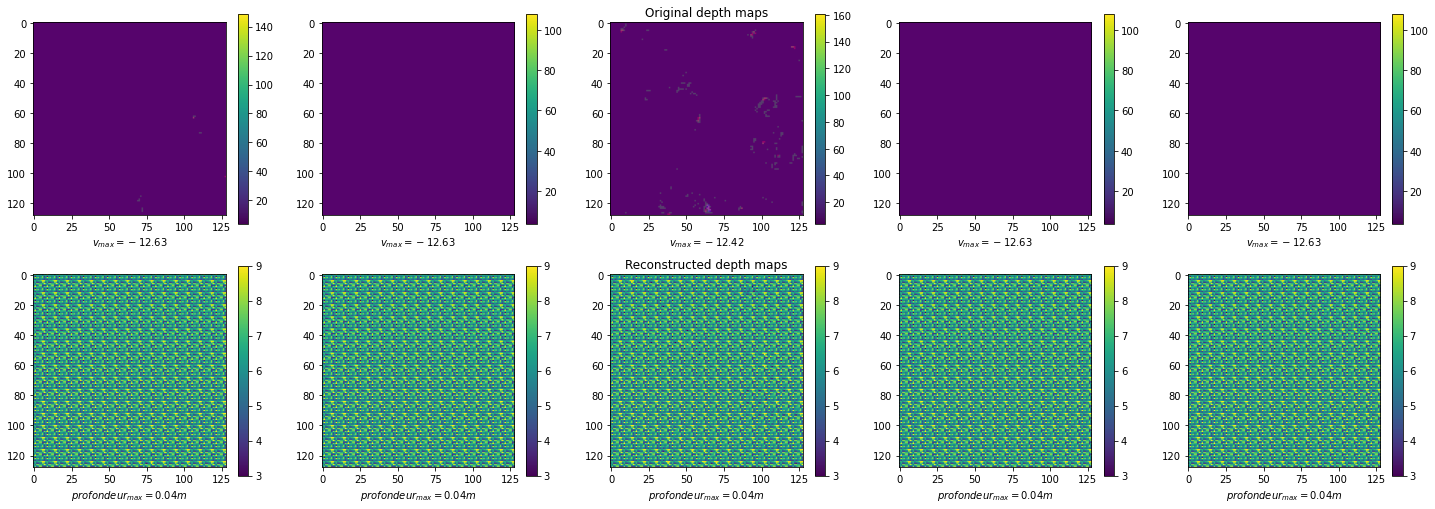

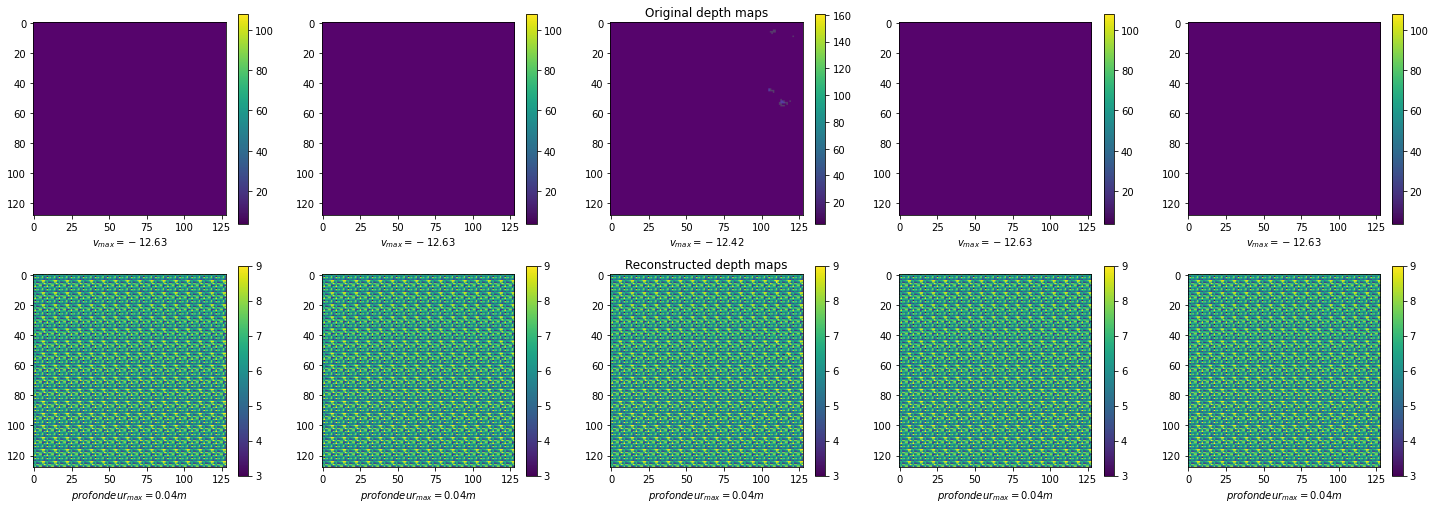

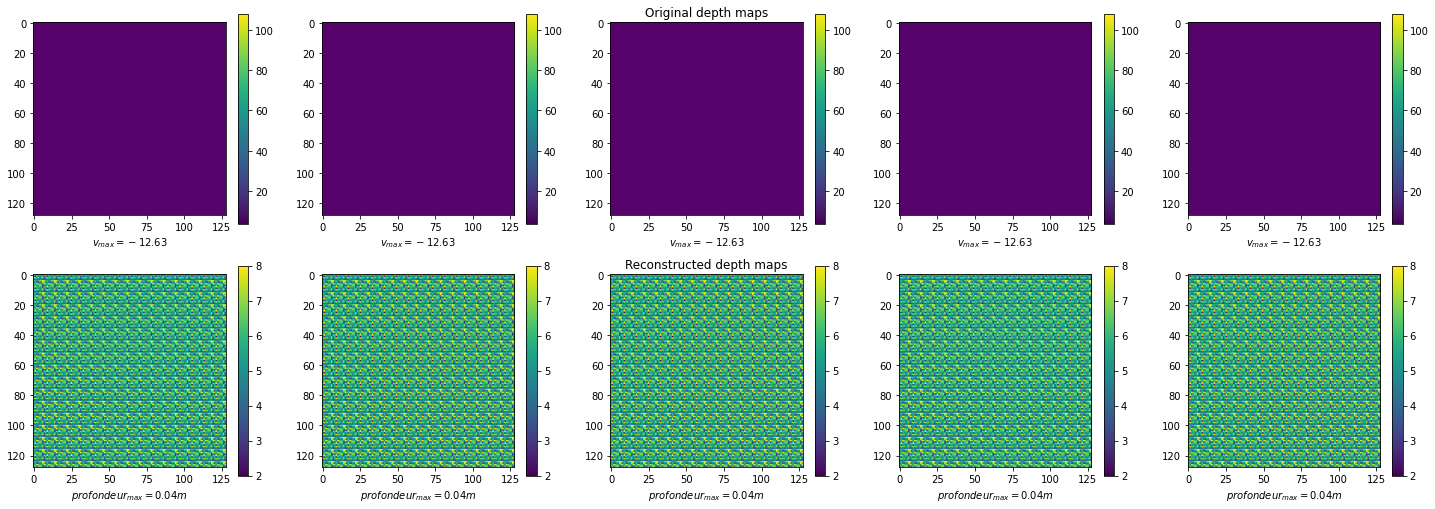

In [30]:
## Training and Validation processes

num_epochs = 5
number_of_plotted_images = 5
plot_images_every_n_epochs = 2
random_plots = True
indices_to_plot = np.arange(number_of_plotted_images)



num_epochs= 10


train_losses = np.array([])
val_losses = np.array([validation_epoch(autoencoder, device, val_loader)])


for epoch in range(num_epochs):
   train_losses_epoch = train_epoch(autoencoder, device, train_loader,optim)
   val_loss_epoch = validation_epoch( autoencoder, device,val_loader)
   train_losses = np.concatenate((train_losses, train_losses_epoch))
   val_losses = np.append(val_losses, val_loss_epoch)
   plot_ae_outputs(autoencoder, number_outputs=number_of_plotted_images, random_plots=random_plots, indices=indices_to_plot)
   print(f'\n EPOCH {epoch + 1}/{num_epochs} \t train loss {train_losses_epoch[-1]:.3f} \t val loss {val_loss_epoch:.3f}')



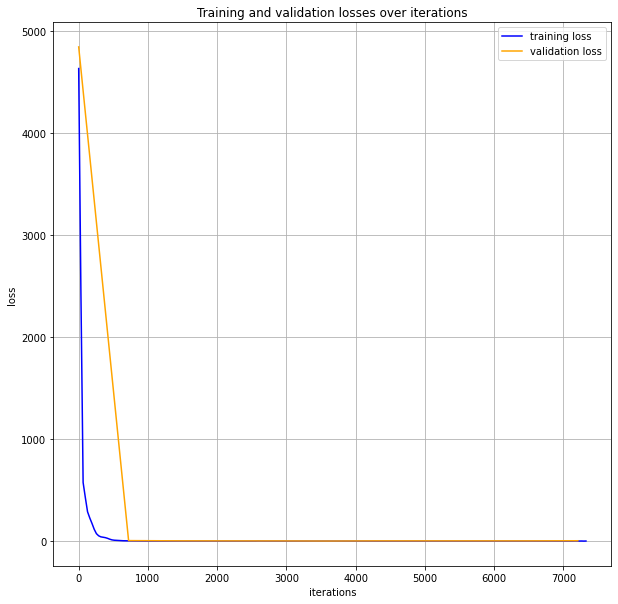

In [31]:
plot_learning_curves(train_losses, val_losses)